# Analyze output of 16s analysis

In [21]:
library(phyloseq)
library(microbiome)
library(dplyr)
library(readr)
library(tidyr)
library(tibble)
library(ggplot2)
library(ggrepel)
library(janitor)

In [4]:
setwd("..")

In [23]:
# adjust plot size rendered inline
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200)

## Read in 16s data as phyloseq data

In [9]:
# create a contamination dataframe to remove mitochondria and chloroplat
bac_tax_contam <- read_tsv("outputs/amplicon/16s/dada2/ASV_taxonomy.tsv", show_col_types = F) %>%
  clean_names() %>%
  filter(family == "Mitochondria" | order == "Chloroplast")

New names:
• `` -> `...1`
Warning message:
“One or more parsing issues, see `problems()` for details”


In [10]:
# all bacterial phyloseq obj
bac_dada <- read_tsv("outputs/amplicon/16s/dada2/ASV_counts.tsv", show_col_types = F) %>%
  clean_names() %>%                            # clean column names
  filter(!x1 %in% bac_tax_contam$x1) %>%       # remove cholorplast and mitochondria
  column_to_rownames("x1") %>%                 # make samples rownames
  as.data.frame()                              # convert to DF

New names:
• `` -> `...1`


In [11]:
# read in and format metadata
info <- read_csv("inputs/hogan_metadata.csv", show_col_types = F) %>%
  as.data.frame() %>%
  filter(grepl(pattern = "^Spu", sample)) %>%  # select only expectorate sputum samples
  filter(!grepl(pattern = "_M$", sample)) %>%  # remove samples treated with metals
  mutate(sample = gsub("Spu", "gd", sample),   # make sample prefix match
         label = sample) %>%                   # create a label vector for plotting
  filter(sample %in% colnames(bac_dada)) %>%   # filter samples to only those with 16s samples
  column_to_rownames("sample")                 # sample as rowname; phyloseq requirement

bac_dada <- bac_dada[ , match(rownames(info), colnames(bac_dada))] # order bac_dada same as info_micro

In [12]:
bac_tax <- read_tsv("outputs/amplicon/16s/dada2/ASV_taxonomy.tsv", show_col_types = F) %>%
  clean_names() %>%
  filter(!x1 %in% bac_tax_contam$x1) %>%
  column_to_rownames("x1") %>%
  as.data.frame()

New names:
• `` -> `...1`
Warning message:
“One or more parsing issues, see `problems()` for details”


In [13]:
bac_physeq <- phyloseq(otu_table(bac_dada, taxa_are_rows = T),
                       tax_table(as.matrix(bac_tax)),
                       sample_data(info))

## Perform ordination analysis on ASVs

ASV: amplicon sequencing variant

In [18]:
dist <- "bray" # define distance
ord_meths <- c("DCA", "CCA", "RDA", "NMDS", "MDS", "PCoA") # define list of ordination methods to use

# define a function to use with llply to batch apply ordination methods
llply_ord <- function(i, physeq, dist){
  ordi <- ordinate(physeq, method=i, distance=dist)
  plot_ordination(physeq, ordi, "samples")
}

# apply ordination methods 
plist <- plyr::llply(as.list(ord_meths), llply_ord, bac_physeq, dist)

# name the list by ordination method
names(plist) <- ord_meths

# transform list into dataframe
pdataframe <- plyr::ldply(plist, function(x){
  df <- x$data[, 1:2]
  colnames(df) <- c("Axis1", "Axis2")
  return(cbind(df, x$data))
})

# name first col of dataframe method
names(pdataframe)[1] <- "method"

Warning message in decorana(veganifyOTU(physeq), ...):
“some species were removed because they were missing in the data”


Square root transformation
Wisconsin double standardization
Run 0 stress 8.632048e-05 
Run 1 stress 7.796174e-05 
... New best solution
... Procrustes: rmse 0.1779672  max resid 0.5705407 
Run 2 stress 9.380134e-05 
... Procrustes: rmse 0.1071152  max resid 0.2731214 
Run 3 stress 9.070533e-05 
... Procrustes: rmse 0.1318394  max resid 0.3761322 
Run 4 stress 9.932904e-05 
... Procrustes: rmse 0.1495702  max resid 0.4074873 
Run 5 stress 6.358991e-05 
... New best solution
... Procrustes: rmse 0.1651026  max resid 0.4482905 
Run 6 stress 9.366229e-05 
... Procrustes: rmse 0.09561799  max resid 0.2523998 
Run 7 stress 9.352194e-05 
... Procrustes: rmse 0.09236839  max resid 0.255656 
Run 8 stress 8.459407e-05 
... Procrustes: rmse 0.05145356  max resid 0.116125 
Run 9 stress 6.922738e-05 
... Procrustes: rmse 0.1686844  max resid 0.4774723 
Run 10 stress 9.03968e-05 
... Procrustes: rmse 0.1806523  max resid 0.5779561 
Run 11 stress 9.335026e-05 
... Procrustes: rmse 0.03549547  max res

Warning message in metaMDS(veganifyOTU(physeq), distance, ...):
“stress is (nearly) zero: you may have insufficient data”


Warning message:
“ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


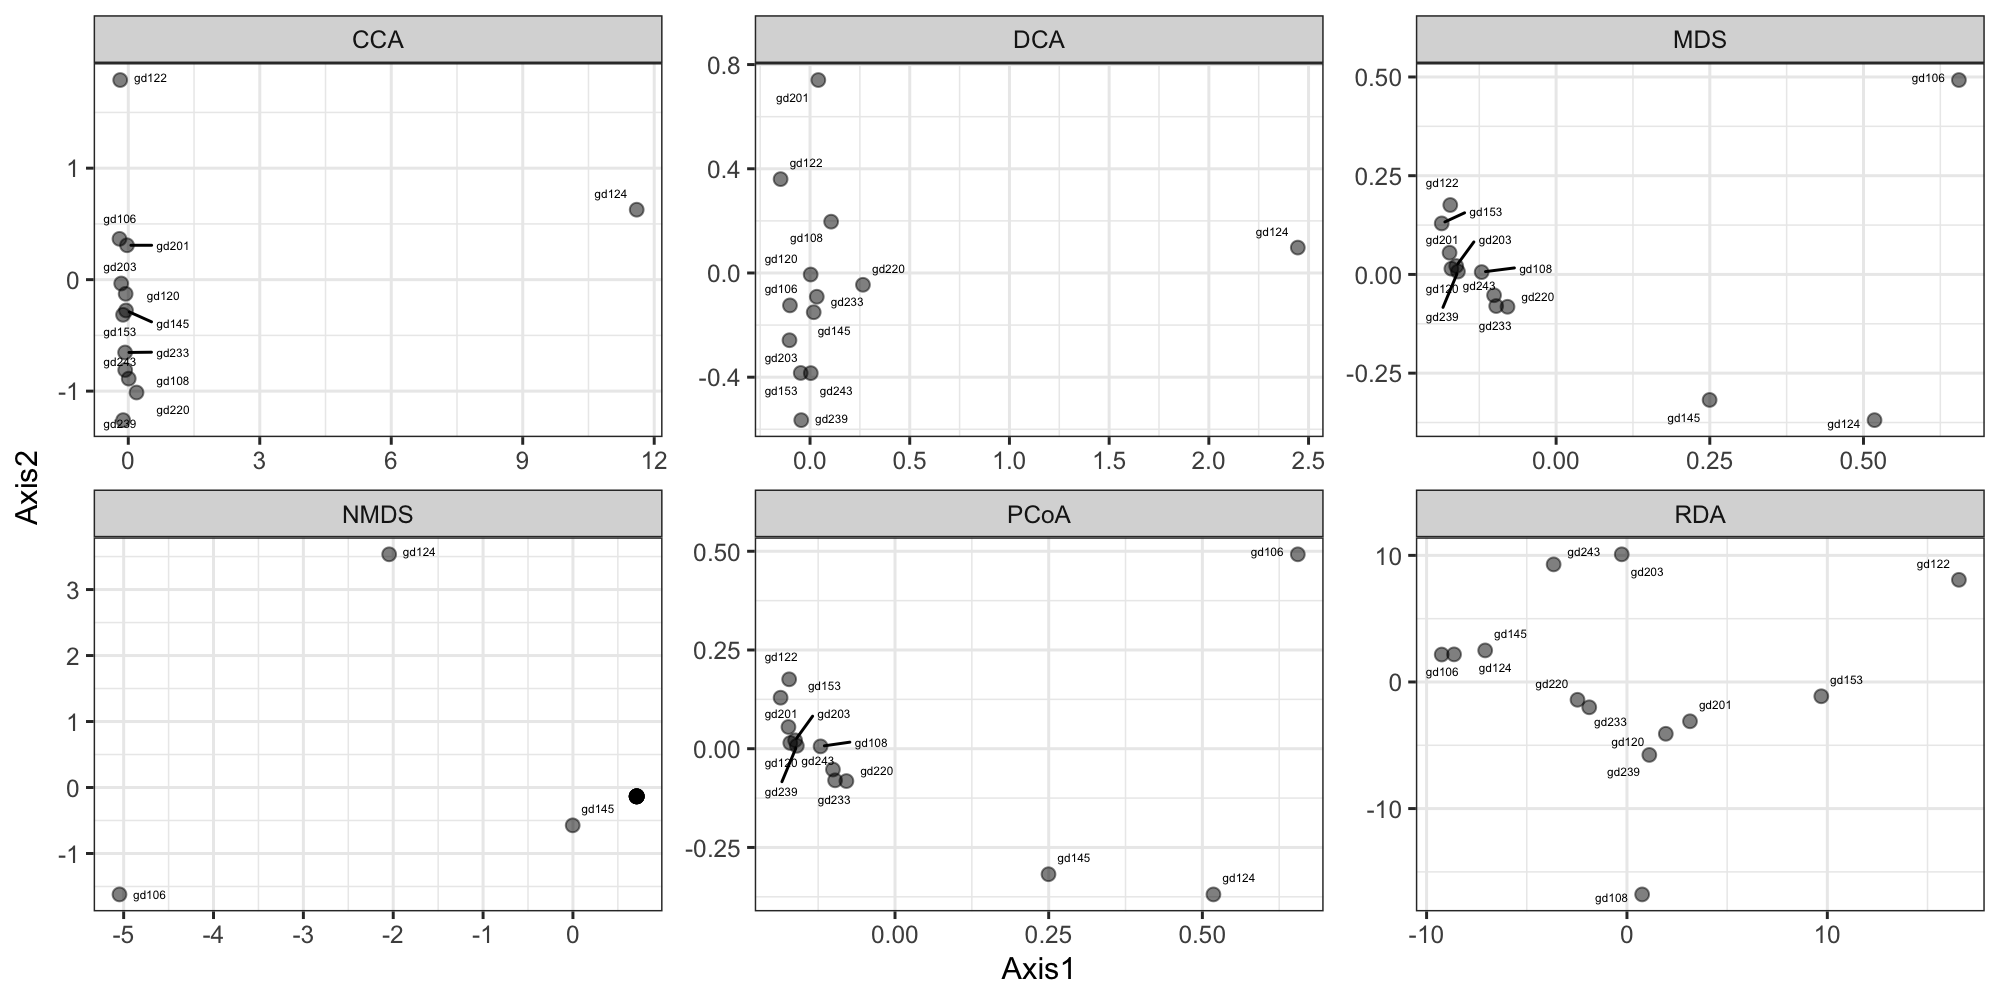

In [24]:
ggplot(pdataframe, aes(Axis1, Axis2, label = label)) +
  geom_point(size=2, alpha = .5) +
  ggrepel::geom_text_repel(size = 1.5) +
  facet_wrap(~method, scales="free") +
  theme_bw()

## aggregate taxa and look at composition

In [33]:
bac_physeq_class <- aggregate_taxa(bac_physeq, level = "class")
bac_physeq_order <- aggregate_taxa(bac_physeq, level = "order")
bac_physeq_phylum <- aggregate_taxa(bac_physeq, level = "phylum")

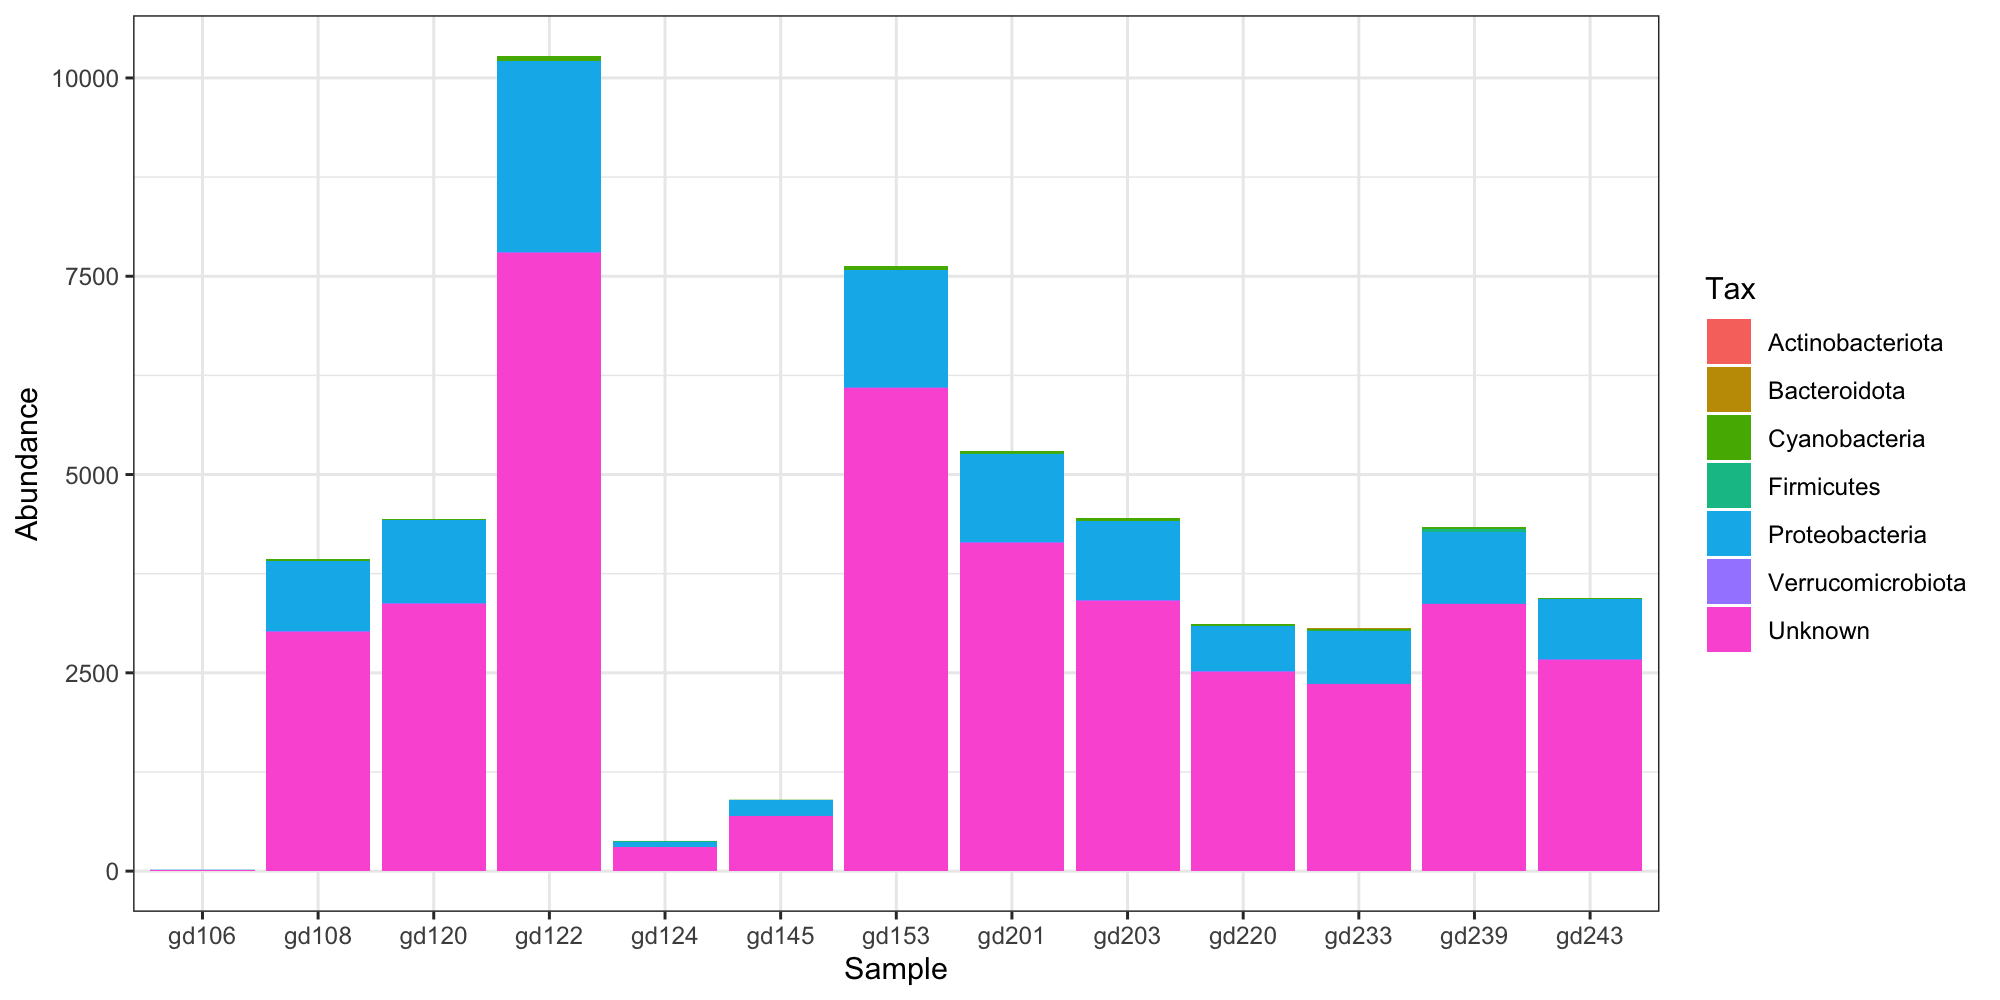

In [31]:
plot_composition(bac_physeq_phylum) + 
  theme_bw()

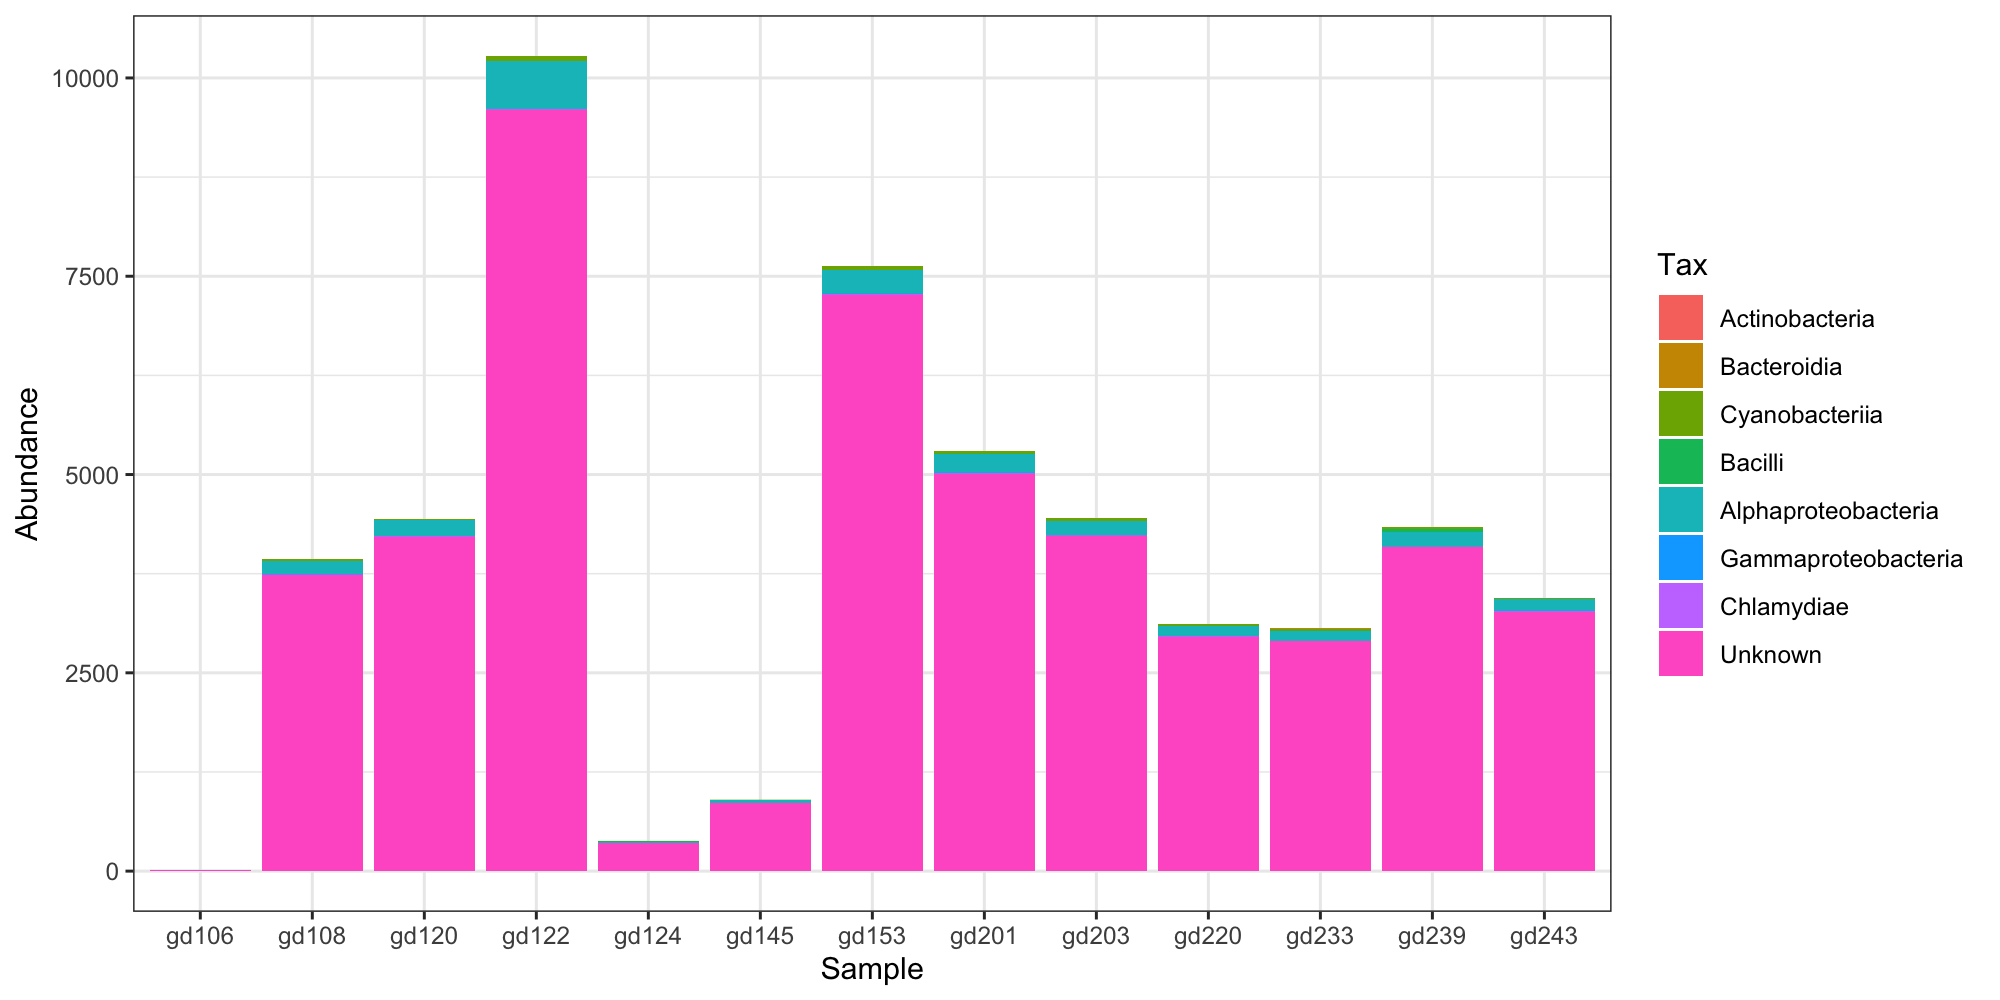

In [35]:
plot_composition(bac_physeq_class) + 
  theme_bw()